# Desafío técnico LATAM

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/Users/Kary/Downloads/dataset_SCL.csv')

In [5]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


## 1. Distribución de los datos

#### 1.1 Análisis

Prácticamente no hay valores nulos en la base de datos. 

In [6]:
print("Tabla 1")
df.isnull().sum()

Tabla 1


Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

La **variable "OPERA" presenta baja variabilidad**: aproximadamente el **60% de los vuelos** son operados por Grupo LATAM, y más del 20% por Sky Airline.

<AxesSubplot:xlabel='OPERA', ylabel='count'>

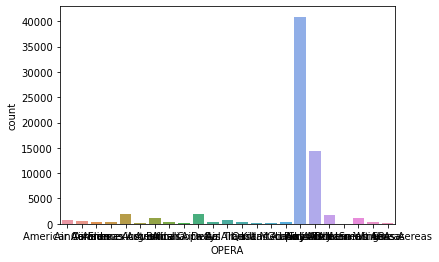

In [7]:
sns.countplot(data=df, x='OPERA')

In [8]:
conteo = df['OPERA'].value_counts()
porcentaje = df['OPERA'].value_counts(normalize=True) * 100

resultados = pd.DataFrame({'conteo': conteo, '%': porcentaje})
print("Tabla 2")
print(resultados)

Tabla 2
                          conteo          %
Grupo LATAM                40892  59.953670
Sky Airline                14298  20.962965
Aerolineas Argentinas       1949   2.857520
Copa Air                    1850   2.712371
Latin American Wings        1674   2.454330
Avianca                     1152   1.689001
JetSmart SPA                1095   1.605431
Gol Trans                    806   1.181714
American Airlines            757   1.109873
Air Canada                   565   0.828373
Iberia                       362   0.530745
Delta Air                    358   0.524881
Air France                   358   0.524881
Aeromexico                   351   0.514617
United Airlines              335   0.491159
Oceanair Linhas Aereas       279   0.409055
Alitalia                     259   0.379732
K.L.M.                       251   0.368003
British Airways              205   0.300560
Qantas Airways               195   0.285899
Lacsa                         92   0.134885
Austral                 

Hay destinos que se repiten notablemente más que otros en la gráfica (Figura 2).

Figura 2


Text(0.5, 1.0, 'Distribución de destinos')

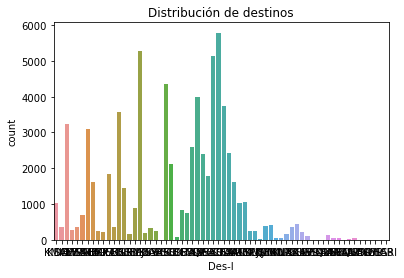

In [9]:
print("Figura 2")
sns.countplot(data=df, x='Des-I')
plt.title('Distribución de destinos')

Se puede observar en la Tabla 3 que algunos destinos solamente aparecen una vez en la base.

In [10]:
conteo = df['Des-I'].value_counts()
porcentaje = df['Des-I'].value_counts(normalize=True) * 100

resultados = pd.DataFrame({'conteo': conteo, '%': porcentaje})
print ("Tabla 3")
print(resultados)

Tabla 3
      conteo         %
SCFA    5787  8.484591
SPJC    5270  7.726593
SCCF    5145  7.543325
SCTE    4357  6.388001
SCIE    3995  5.857256
...      ...       ...
SBFI       1  0.001466
SPSO       1  0.001466
SEQU       1  0.001466
SEQM       1  0.001466
SARI       1  0.001466

[64 rows x 2 columns]


Los días sábado presentan menor cantidad de vuelos, mientras que en los días lunes, jueves y viernes se ve un alza. El resto de los días de la semana distribuyen de manera similar. 

Figura 3


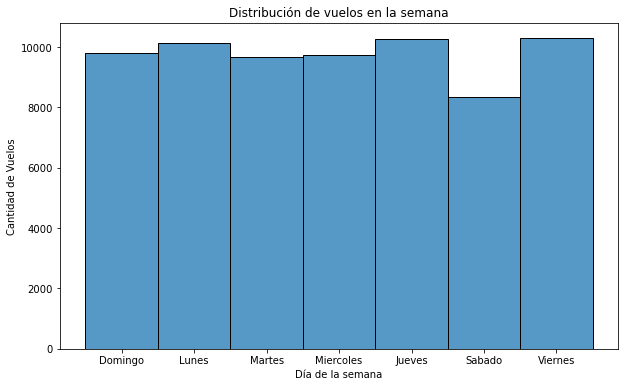

In [11]:
print("Figura 3")
plt.figure(figsize=(10, 6))
sns.histplot(df['DIANOM'], bins=50)
plt.title('Distribución de vuelos en la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de Vuelos')
plt.show()

In [12]:
#df["Ori-I"].hist()
#df["Ori-O"].hist()

In [13]:
# Número de vuelos donde Des-I es diferente a Des-O
des = df[df['Des-I'] != df['Des-O']].shape[0]

# Número de vuelos donde Vlo-I es diferente a Vlo-O
vlo = df[df['Vlo-I'] != df['Vlo-O']].shape[0]

# Número de vuelos donde Ori-I es diferente a Ori-O
ori = df[df['Ori-I'] != df['Ori-O']].shape[0]

# Número de vuelos donde Emp-I es diferente a Emp-O
emp = df[df['Emp-I'] != df['Emp-O']].shape[0]

print(f"Existen {des} vuelos que cambiaron su destino programado.")
print(f"Existen {vlo} vuelos que cambiaron el número de vuelo programado.")
print(f"Existen {ori} vuelos que cambiaron su origen programado.")
print(f"Existen {emp} vuelos que cambiaron su aerolínea programada.")

Existen 28 vuelos que cambiaron su destino programado.
Existen 1850 vuelos que cambiaron el número de vuelo programado.
Existen 0 vuelos que cambiaron su origen programado.
Existen 18669 vuelos que cambiaron su aerolínea programada.


Los destinos Des-I/Des-O no necesariamente equivalen al destino en SIGLADES (Tabla 4). Esto se puede comprobar comparando, por ejemplo, los datos de índice **16937** y **37162** de la Tabla 4. Se utilizará esto para supuestos que se explican en el punto 1.2. 

In [14]:
data = df[df['Des-I'] != df['Des-O']]
data = data[['Des-I', 'Des-O', 'SIGLADES']].drop_duplicates()
print("Tabla 4")
data

Tabla 4


,Des-I,Des-O,SIGLADES
1397,SCTE,SCQP,Temuco
7520,SCIE,SCQP,Temuco
12823,SCBA,SCTE,Puerto Montt
16169,KJFK,KMIA,Miami
16937,SEGU,SABE,Buenos Aires
20444,SCTE,SCCI,Punta Arenas
24569,SCFA,SCCF,Calama
33166,SBGR,SBGL,Rio de Janeiro
37162,SABE,SAEZ,Buenos Aires
39265,KIAH,KIAD,Washington


#### 1.2. Observaciones

La poca diversidad de los valores de la variable OPERA puede significar que su capacidad predictiva esté sesgada o no sea útil. Más adelante se analizará si es que esta variable aporta valor significativo al modelo o no, para considerar su eliminación. 

Por otro lado, se podrían quitar los outliers de la variable DES-I ya que, como se puede ver en la Tabla 3, hay destinos que **aparecen únicamente una vez** en la base. 

Las variables Ori-I, Ori-O, SIGLAORI y AÑO no se considerarán relevantes, ya que repiten únicamente un mismo valor (AÑO tiene un solo valor distinto a 2017). Además, como el origen siempre es Santiago, **el problema no abarca atrasos de vuelos que aterrizan en Santiago**, solamente aquellos que despegan. 

Son muy pocos los vuelos que cambiaron su destino programado (28 de un universo de 68.200), por ende se podría considerar que las variables Des-I y Des-O son equivalentes (aunque representen cosas distintas) y se eliminará una de las dos.

Por último, como se mencionó en el punto 1.1., el destino SIGLADES no equivale a Des-I ni Des-O. Debido a esto, **se van a hacer las siguientes suposiciones**: 
- Des-I corresponde al destino programado del **vuelo**, no del viaje
- Des-O corresponde al destino de operación del **vuelo**, no del viaje
- SIGLADES corresponde al destino del **viaje**, no necesariamente del vuelo 

Para aclarar lo anterior, se puede considerar como ejemplo un viaje que presenta una escala. El destino final del viaje corresponde a SIGLADES, mientras que los destinos Des-I/Des-O toman como valor la ciudad donde se hace una escala y la del destino final del viaje. 

##  2. Construcción de variables


#### 2.1 Construcción

In [15]:
# Pasar fechas a formato datetime
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# Crear variable min_diff como diferencia entre Fecha-O y Fecha-I, en minutos
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60  # en minutos

# Crear variable delay_15
df['delay_15'] = (df['min_diff'] > 15).astype(int)

# Función que retorna una binaria con el valor 1 cuando Fecha-I está entre Dic-15 y Mar-3, o Jul-15 y Jul-31, o Sep-11 y Sep-30
def is_high_season(date):
    if ((date.month == 12 and date.day >= 15) or (date.month == 1) or (date.month == 2) or (date.month == 3 and date.day <= 3) or
        (date.month == 7 and date.day >= 15 and date.day <= 31) or
        (date.month == 9 and date.day >= 11 and date.day <= 30)):
        return 1
    else:
        return 0
    
# Aplicar la función anterior a la base para crear la variable high_season
df['high_season'] = df['Fecha-I'].apply(is_high_season)

# Función que retorna los valores "morning", "afternoon" o "night" dependiendo de la hora programada del vuelo (Fecha-I)
def period_of_day(timestamp):
    hour = timestamp.hour
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 19:
        return 'afternoon'
    else:
        return 'night'
    
# Aplicar función anterior a la base para crear la variable period_day
df['period_day'] = df['Fecha-I'].apply(period_of_day)

#### 2.2. Exportación

In [16]:
#df[['min_diff', 'delay_15', 'high_season', 'period_day']].to_csv('synthetic_features.csv', index=False)

## 3. Comportamiento de variables con respecto al delay

La mayoría de los vuelos no están considerados como atrasados (Figura 4), por lo tanto hay un **desbalance en la data** que tendrá que trabajarse con algún método de balanceo. 

Figura 4


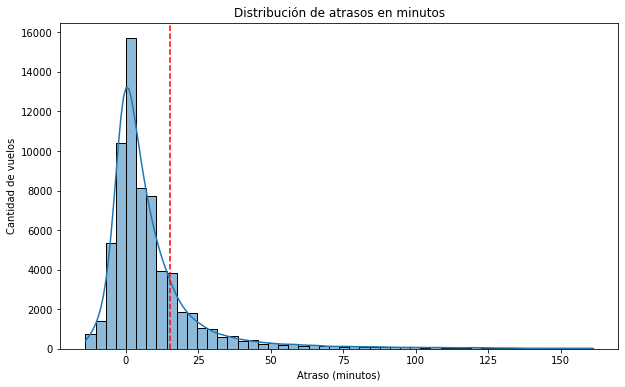

*La línea vertical roja representa el valor desde donde se comienza a considerar el vuelo como atrasado (15 minutos)


In [17]:
print("Figura 4")
plt.figure(figsize=(10, 6))
sns.histplot(df['min_diff'], bins=50, kde=True) 
plt.axvline(15, color='red', linestyle='--', label='x = 15')
plt.title('Distribución de atrasos en minutos')
plt.xlabel('Atraso (minutos)')
plt.ylabel('Cantidad de vuelos')
plt.show()
print("*La línea vertical roja representa el valor desde donde se comienza a considerar el vuelo como atrasado (15 minutos)")


Del Set de Figuras 1 se puede observar lo siguiente:
- El atraso varía según el destino
- Hay aerolíneas con mayor atraso que otras (Figura 5). Sin embargo, cabe recordar que la gran mayoría de los vuelos en la base de datos están operados por Grupo LATAM o por Sky Airline, por ende no se puede asumir que la variable será significativa
- Los meses de julio y diciembre presentan mayor atraso que el resto
- No se observa diferencia en el atraso para las variables de día de la semana, temporada alta y tipo de vuelo

Set de Figuras 1


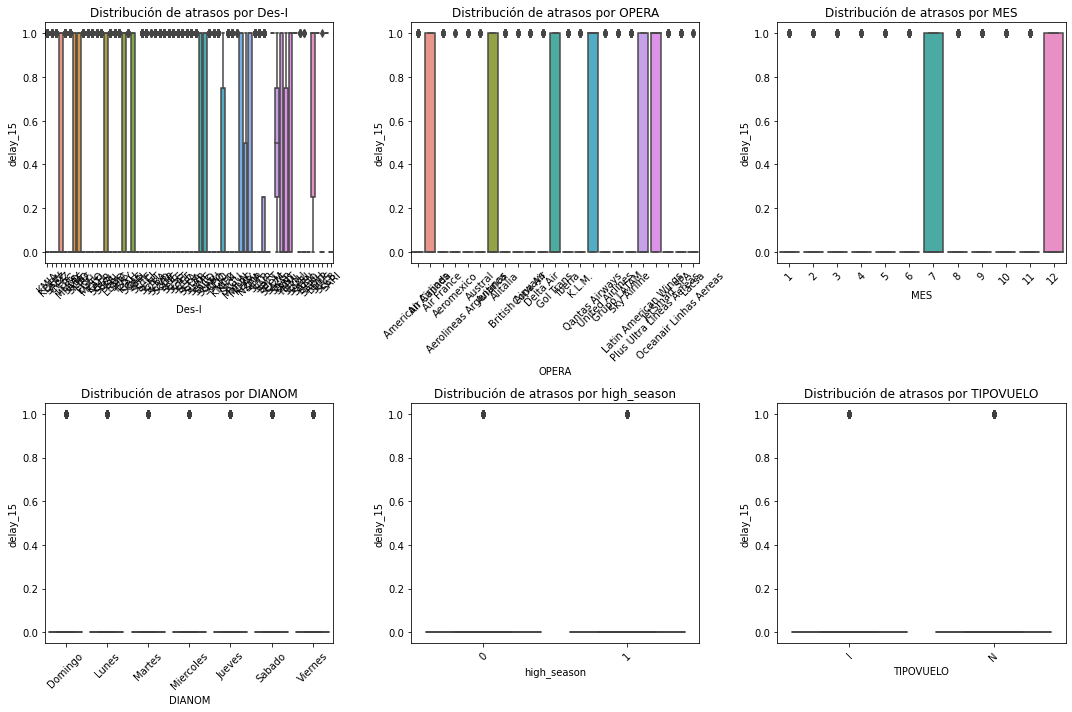

In [18]:
print("Set de Figuras 1")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

variables = ['Des-I','OPERA', 'MES', 'DIANOM', 'high_season', 'TIPOVUELO']

for ax, variable in zip(axes.flatten(), variables):
    sns.boxplot(x=variable, y='delay_15', data=df, ax=ax)
    ax.set_title(f'Distribución de atrasos por {variable}')
    ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

Dado lo anterior, esperaría que las variables con mayor impacto en la predicción del atraso correspondan al mes del año y destino. 

## 4. Entrenamiento

#### 4.1. Variables adicionales

Se crearán las siguientes variables:
- **n_vuelos_30min_destino**: cantidad de vuelos programados en un intervalo de 30 minutos (+-15 min) que viajan de Santiago al mismo destino
- **n_vuelos_30min**: cantidad de vuelos programados que salen de Santiago en un intervalo de 30 minutos (+-15 min)
- **atrasos_1d_destino**: cantidad de vuelos que se atrasaron el día anterior hacia el mismo destino
- **atrasos_1d**: cantidad de vuelos que se atrasaron el día anterior
- **historial_atrasos_destino**: promedio de atrasos que hubo en los últimos 15 días hacia el destino del vuelo
- **historial_atrasos_vuelo**: promedio de atrasos que tuvo el número de vuelo en los últimos 15 días
- **historial_atrasos_opera**: promedio de atrasos de la aerolínea que opera en los últimos 15 días
- **mantiene_aerolinea**: binaria que toma el valor 1 si es que la aerolínea programada sufrió un cambio*

Se asume que se desconocen las fechas operacionales de vuelos de las últimas 24 hrs, pero sí están disponibles los datos programados. Esto quiere decir que cuando se habla del "día anterior" para el cálculo de atrasos, en realidad es el intervalo desde las últimas 48 hrs. hasta las últimas 24 hrs. 

*No se estimó necesario hacer lo mismo para el resto de variables var-I/var-O ya que, como se vio en el análisis de distribución, existen muy pocos datos donde hubo un cambio sobre lo programado.


In [19]:
def contar_vuelos_30min_des(group):
    return group.apply(lambda row: ((group['Fecha-I'] >= row['Fecha-I'] - pd.Timedelta(minutes=15)) &
                                    (group['Fecha-I'] <= row['Fecha-I'] + pd.Timedelta(minutes=15))).sum() - 1, axis=1)

df['n_vuelos_30min_destino'] = df.groupby('Des-I').apply(contar_vuelos_30min_des).reset_index(level=0, drop=True)
df['n_vuelos_30min'] = contar_vuelos_30min(df)

In [21]:
df = df.sort_values(by=['Des-I', 'Fecha-I'])

def contar_atrasos_grupo_des(group):
    return group['Fecha-I'].apply(lambda x: len(group[(group['Fecha-I'] < x - pd.Timedelta(hours=24)) & 
                                                      (group['Fecha-I'] >= x - pd.Timedelta(hours=48)) & 
                                                      (group['delay_15'])]))

df['atrasos_1d_destino'] = df.groupby('Des-I').apply(contar_atrasos_grupo_des).reset_index(level=0, drop=True)
df['atrasos_1d'] = contar_atrasos_grupo(df)

In [23]:
def historial_atrasos(group):
    group_dates = group['Fecha-I'].values  # Vector de fechas del grupo
    results = []

    for date in group_dates:
        # Definir el rango de fechas para el historial (en este caso, los últimos 15 días)
        start_date = date - pd.Timedelta(days=15)
        end_date = date - pd.Timedelta(days=1)
        mask = (group_dates >= start_date) & (group_dates < end_date)
        mean_delay = group['delay_15'][mask].mean()
        results.append(mean_delay)

    return pd.Series(results, index=group.index)

df['historial_atrasos_destino'] = df.groupby('Des-I').apply(historial_atrasos).reset_index(level=0, drop=True)
df['historial_atrasos_destino'] = df['historial_atrasos_destino'].fillna(0)
df['historial_atrasos_vuelo'] = df.groupby('Vlo-I').apply(historial_atrasos).reset_index(level=0, drop=True)
df['historial_atrasos_vuelo'] = df['historial_atrasos_vuelo'].fillna(0)
df['historial_atrasos_opera'] = df.groupby('OPERA').apply(historial_atrasos).reset_index(level=0, drop=True)
df['historial_atrasos_opera'] = df['historial_atrasos_opera'].fillna(0)

In [24]:
df['mantiene_aerolinea'] = (df['Emp-I'] == df['Emp-O']).astype(int)

#### 4.2. Pre-procesamiento

In [25]:
df = df.dropna()

Las variables **Des-I y SIGLADES están relacionadas significativamente**. Esto se puede comprobar con un test de significancia y se observa al ver el comportamiento de atrasos de ambas (Set de Figuras 2). Se podría elegir una variable y descartar la otra, pero como se vio anteriormente, las variables contienen datos distintos, por lo tanto **se decide concatenarlas** en una variable compuesta denominada **'des_comp'**. 

In [26]:
contingency_table = pd.crosstab(df['Des-I'], df['SIGLADES'])

# Realizar prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequency table:")
print(expected)

alpha = 0.05  # Nivel de significancia
if p < alpha:
    print("Se rechaza la hipótesis nula. Las variables tienen una relación significativa.")
else:
    print("No se rechaza la hipótesis nula.")

Chi2 value: 4088933.801632338
P-value: 0.0
Degrees of freedom: 3843
Expected frequency table:
[[2.40075948e+01 1.01075874e+01 9.62627373e-01 ... 2.48955355e-02
  3.12438971e+00 4.14925592e-03]
 [1.73906605e+01 7.32175060e+00 6.97309581e-01 ... 1.80338685e-02
  2.26325049e+00 3.00564475e-03]
 [8.48324903e-02 3.57158566e-02 3.40151015e-03 ... 8.79700902e-05
  1.10402463e-02 1.46616817e-05]
 ...
 [9.04314346e+01 3.80731031e+01 3.62600982e+00 ... 9.37761161e-02
  1.17689026e+01 1.56293527e-02]
 [3.22363463e+00 1.35720255e+00 1.29257386e-01 ... 3.34286343e-03
  4.19529360e-01 5.57143904e-04]
 [1.65423356e+01 6.96459204e+00 6.63294480e-01 ... 1.71541676e-02
  2.15284803e+00 2.85902793e-03]]
Se rechaza la hipótesis nula. Las variables tienen una relación significativa.


Set de Figuras 2


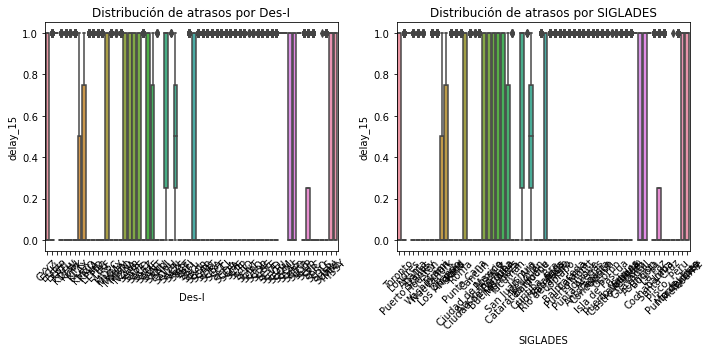

In [27]:
print("Set de Figuras 2")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

variables = ['Des-I','SIGLADES']

for ax, variable in zip(axes.flatten(), variables):
    sns.boxplot(x=variable, y='delay_15', data=df, ax=ax)
    ax.set_title(f'Distribución de atrasos por {variable}')
    ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

In [28]:
df['des_comp'] = df['Des-I'] + df['SIGLADES']

De la misma forma, se crea la variable **'opera_comp'** compuesta por **Emp-O y OPERA**. 

In [29]:
contingency_table = pd.crosstab(df['Emp-O'], df['OPERA'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequency table:")
print(expected)

alpha = 0.05  
if p < alpha:
    print("Se rechaza la hipótesis nula. Las variables tienen una relación significativa.")
else:
    print("No se rechaza la hipótesis nula. Las variables son independientes.")

Chi2 value: 1439454.191226147
P-value: 0.0
Degrees of freedom: 682
Expected frequency table:
[[2.85756176e-01 5.14625027e-02 8.28385016e-02 5.24888205e-02
  3.79737556e-02 1.10988930e-01 1.08496445e-02 1.68902573e-01
  3.00564475e-02 2.71241111e-01 5.24888205e-02 1.18173154e-01
  5.99545488e+00 5.30752877e-02 1.60545415e-01 3.68008211e-02
  1.34887472e-02 2.45289935e-01 4.09060919e-02 7.18422403e-03
  2.85902793e-02 2.09632725e+00 4.91166337e-02]
 [4.57209882e-01 8.23400044e-02 1.32541603e-01 8.39821127e-02
  6.07580089e-02 1.77582289e-01 1.73594311e-02 2.70244117e-01
  4.80903160e-02 4.33985778e-01 8.39821127e-02 1.89077047e-01
  9.59272781e+00 8.49204604e-02 2.56872663e-01 5.88813137e-02
  2.15819955e-02 3.92463896e-01 6.54497471e-02 1.14947584e-02
  4.57444469e-02 3.35412360e+00 7.85866139e-02]
 [2.16317425e+01 3.89571146e+00 6.27087457e+00 3.97340371e+00
  2.87461330e+00 8.40186203e+00 8.21318085e-01 1.27859248e+01
  2.27527307e+00 2.05329521e+01 3.97340371e+00 8.94570779e+00
  4.5

Set de Figuras 3


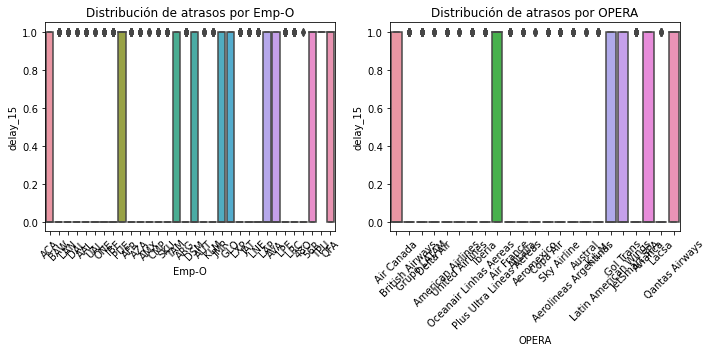

In [30]:
print("Set de Figuras 3")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

variables = ['Emp-O','OPERA']

for ax, variable in zip(axes.flatten(), variables):
    sns.boxplot(x=variable, y='delay_15', data=df, ax=ax)
    ax.set_title(f'Distribución de atrasos por {variable}')
    ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

In [31]:
df['opera_comp'] = df['Emp-O'] + df['OPERA']

Se excluyen las variables que no se usarán directamente en el modelo. La justificación de cada una está a continuación:
- Ori-I, Ori-O, AÑO y SIGLAORI tienen un único valor
- Fecha-I, Fecha-O y min_diff fueron utilizadas para crear la variable dependiente
- Vlo-O tiene el mismo valor que Vlo-I en más del 97% de los casos, por ende, se usará solo Vlo-I
- Des-I y SIGLADES se utilizaron para crear la variable compuesta des_comp
- Des-O tiene el mismo valor que Des-I en casi el 100% de los casos

In [32]:
excluir = ['Ori-I', 'Fecha-I', 'Fecha-O', 'Vlo-O', 'Ori-O', 'Des-O', 'AÑO', 'SIGLAORI', 'min_diff', 'SIGLADES', 'Emp-O', 'OPERA', 'Des-I']
data = df.drop(columns=excluir)

Solamente se categorizarán de manera numérica las variables que tienen algún tipo de orden: día de la semana y momento del día. El resto se transformará a binaria. En particular para TIPOVUELO, se hizo una transformación directa ya que tiene solo dos posibles valores.

In [33]:
data['DIANOM'] = data['DIANOM'].replace({
    "Lunes": 1,
    "Martes": 2,
    "Miercoles": 3,
    "Jueves": 4,
    "Viernes": 5,
    "Sabado": 6,
    "Domingo": 7
})

data['period_day'] = data['period_day'].replace({
    "morning": 1,
    "afternoon": 2,
    "night": 3
})

data['TIPOVUELO'] = data['TIPOVUELO'].replace({
    "N": 0,
    "I": 1
})

In [34]:
data = pd.get_dummies(data, columns=['Emp-I','opera_comp', 'des_comp', 'Vlo-I'])

Se puede ver que la data está desbalanceada. 

In [35]:
data['delay_15'].value_counts()

0    55591
1    12614
Name: delay_15, dtype: int64

No se ven correlaciones fuertes con la variable dependiente que puedan sesgar el modelo más adelante. 

In [36]:
data.corr()['delay_15'].sort_values(ascending=False)

delay_15                         1.000000
historial_atrasos_vuelo          0.235177
historial_atrasos_opera          0.212017
historial_atrasos_destino        0.199520
atrasos_1d                       0.106860
                                   ...   
des_comp_SCCFCalama             -0.046120
Emp-I_CMP                       -0.052571
opera_comp_CMPCopa Air          -0.052571
des_comp_MPTOCiudad de Panama   -0.052571
opera_comp_LXPGrupo LATAM       -0.057547
Name: delay_15, Length: 906, dtype: float64

#### 4.3. Entrenamiento

Se utilizará el metodo SMOTE para el balance de las clases.

In [37]:
# Dividir en entrenamiento y prueba
X = data.drop('delay_15', axis=1)
y = data['delay_15']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Smote para tratar el desbalance de clases
smote = SMOTE(random_state=42)

X_res, y_res = smote.fit_resample(X_train, y_train)

 **Random Forest**

In [38]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

**Logistic Regression**

In [39]:
logreg = LogisticRegression()
logreg.fit(X_res, y_res)

LogisticRegression()

**LightGBM**

In [40]:
train_data = lgb.Dataset(X_res, label=y_res)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 100
bst = lgb.train(params, train_data, num_round)

[LightGBM] [Info] Number of positive: 44480, number of negative: 44480
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7273
[LightGBM] [Info] Number of data points in the train set: 88960, number of used features: 565
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


**Decision Tree**

In [41]:
tree = DecisionTreeClassifier()
tree.fit(X_res, y_res)

DecisionTreeClassifier()

## 5. Evaluación

#### 5.1. Elección de modelo

Para evaluar el modelo se analizará el **f1-score y la matriz de confusión**. Como se trata de un problema con **clases desbalanceadas**, el accuracy no es la métrica ideal porque no distingue tipo de error específico (falsos positivos, falsos negativos). La precisión y el recall sí los consideran, y el f1 score combina ambas en una sola métrica (media armónica). 

**Random Forest**

              precision    recall  f1-score   support

           0       0.85      0.93      0.88     11111
           1       0.45      0.26      0.33      2530

    accuracy                           0.80     13641
   macro avg       0.65      0.59      0.61     13641
weighted avg       0.77      0.80      0.78     13641



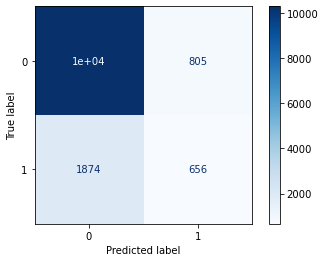

In [42]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Logistic Regression**

              precision    recall  f1-score   support

           0       0.88      0.67      0.76     11111
           1       0.30      0.60      0.40      2530

    accuracy                           0.66     13641
   macro avg       0.59      0.64      0.58     13641
weighted avg       0.77      0.66      0.70     13641



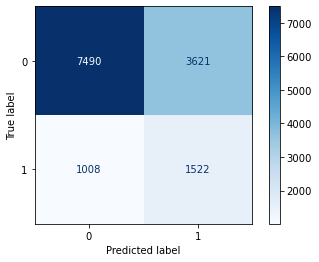

In [43]:
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**LightGBM**

              precision    recall  f1-score   support

           0       0.83      0.98      0.90     11111
           1       0.56      0.14      0.22      2530

    accuracy                           0.82     13641
   macro avg       0.70      0.56      0.56     13641
weighted avg       0.78      0.82      0.77     13641



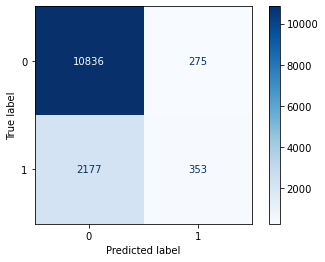

In [44]:
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Decision Tree**

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     11111
           1       0.28      0.28      0.28      2530

    accuracy                           0.73     13641
   macro avg       0.56      0.56      0.56     13641
weighted avg       0.73      0.73      0.73     13641



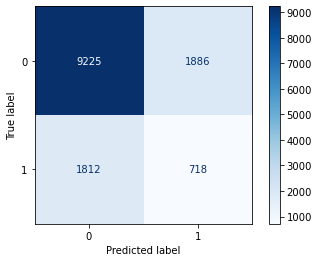

In [45]:
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

A priori, el modelo con mejor desempeño corresponde al **Random Forest**\*. Se testearán los mejores modelos usando **cross validation** para comprobar si el desempeño de Random Forest es consistentemente mejor.

*Se podría pensar que LightGBM es mejor debido al accuracy, pero la métrica de interés es el f1 score. Además, se busca lograr predecir los atrasos, y los resultados de la matriz de confusión de LightGBM muestran que el modelo está prediciendo la clase 0 (vuelo no atrasado) con demasiada frecuencia.

In [46]:
# AVISO: Dado que se está entrenando el modelo de Random Forest varias veces, este bloque se demora aprox. 7 minutos en ejecutar.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(rf, X_res, y_res, cv=skf, scoring='f1')

print("Resultados Random Forest")
print("F1 score por fold: ", scores)
print("F1 score promedio: ", scores.mean())
print("Desviación estándar: ", scores.std())

Resultados Random Forest
F1 score por fold:  [0.8953802  0.89960159 0.89699743 0.89789636 0.89769659]
F1 score promedio:  0.8975144343347777
Desviación estándar:  0.0013680300223283173


In [47]:
scores = cross_val_score(tree, X_res, y_res, cv=skf, scoring='f1')

print("Resultados Decision Tree")
print("F1 score por fold: ", scores)
print("F1 score promedio: ", scores.mean())
print("Desviación estándar: ", scores.std())

Resultados Decision Tree
F1 score por fold:  [0.82324346 0.82921057 0.82901262 0.82976439 0.82556112]
F1 score promedio:  0.8273584327357693
Desviación estándar:  0.0025345127583644603


In [49]:
scores = cross_val_score(logreg, X_res, y_res, cv=skf, scoring='f1')

print("Resultados Logistic Regression")
print("F1 score por fold: ", scores)
print("F1 score promedio: ", scores.mean())
print("Desviación estándar: ", scores.std())

Resultados Logistic Regression
F1 score por fold:  [0.65271532 0.65102064 0.65063422 0.65260758 0.65118958]
F1 score promedio:  0.651633470247656
Desviación estándar:  0.0008591147626868878


Finalmente, el **mejor modelo** es el de **Random Forest**. 

#### 5.2. Observaciones

Las 5 variables más importantes en el modelo resultan ser:
- Promedio de atrasos de los últimos 15 días (historial) del número de vuelo, aerolínea que opera y de vuelos hacia el mismo destino
- Cantidad de atrasos en el último día (desde las últimas 48 hrs hasta las últimas 24 hrs)
- Día del mes
- Día de la semana
- Cantidad de vuelos programados en un intervalo de 30 minutos (+- 15 min)

Figura 5


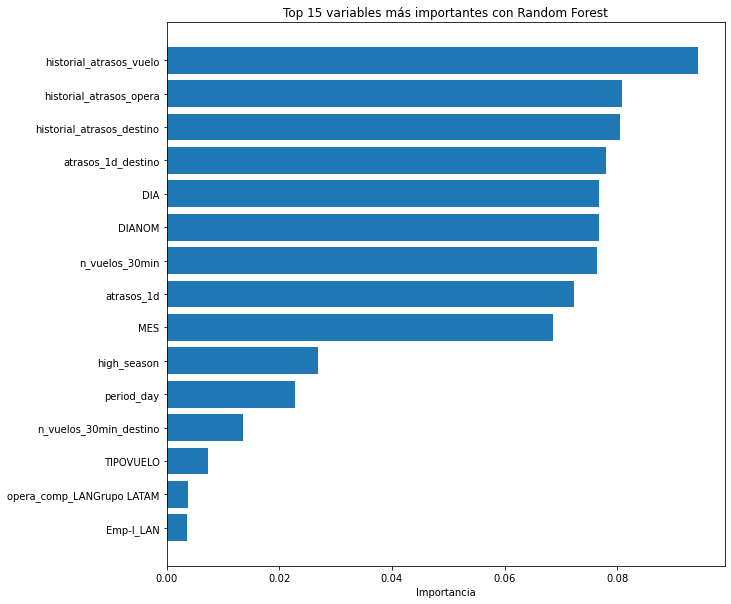

In [48]:
importances = rf.feature_importances_
features = X.columns

sorted_idx = importances.argsort()

# Seleccionar las 15 más importantes
top_15 = sorted_idx[-15:]
#bottom_10 = sorted_idx[:20] 
selected_idx = list(top_15)

print("Figura 5")
plt.figure(figsize=(10, 10))
plt.barh(features[selected_idx], importances[selected_idx])
plt.xlabel("Importancia")
plt.title("Top 15 variables más importantes con Random Forest")
plt.show()

Por último, cabe mencionar que el modelo fue escogido de acuerdo a las métricas mencionadas. Sin embargo, **el mejor modelo podría depender de los objetivos que busca el problema** (más allá de la predicción del atraso). Por ejemplo, si la penalización por no predecir un atraso es mayor que aquella por predecir erróneamente un atraso, podría ser más conveniente optar por el modelo de Decision Tree, ya que en su matriz de confusión presenta una mayor cantidad de verdaderos positivos (pese a que también presenta más falsos positivos que Random Forest). Es decir, la decisión va a depender de un contexto y objetivo dado. 

#### 5.3. Aspectos a mejorar

Se podría mejorar el desempeño del modelo desde varios aspectos, entre ellos: 
- **Datos internos**: Se podrían incorporar datos internos relacionados al vuelo tales como tipo de avión; fecha de último mantenimiento del avión; si corresponde a vuelo directo o con escalas (o en su defecto, cantidad de tramos); capacidad del aeropuerto; número de pasajeros; duración estimada del vuelo.
- **Datos externos**: Hay datos externos que también podrían afectar el atraso del vuelo: si es en una fecha festiva; condiciones climáticas; estación del año en país de origen/destino. 
- **Balance de clases**: Uno de los problemas que se abordó corresponde al desbalance de clases. En este caso se trabajó con el método SMOTE y modelos basados en árboles, sin embargo, se podrían probar otros métodos tales como el remuestreo o aplicar parámetros de penalización. 
- **Modelo**: En este problema se hizo un entrenamiento y testeo simple de distintos modelos de clasificación, sin embargo, esto se puede complejizar para buscar un modelo que tenga mejor poder predictivo. Por ejemplo, se puede trabajar con subconjuntos de datos de testeo, entrenamiento y validación (en lugar de únicamente testeo y entrenamiento), y aplicar técnicas de búsquedas de hiperparámetros para el modelo (como **GridSearch**). Por otro lado, se podría quitar el escalamiento realizado con el StandarScaler considerando que se está usando un modelo basado en árboles (estos tienden a ser invariantes a la escala).